In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# implementation of nueral netwroks model
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

2024-03-15 20:32:50.145427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 20:32:50.145580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 20:32:50.304937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# also set a random state
rs = 123

In [4]:
# Point to the datasets stored on the cloud
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
ratings_df = pd.read_csv(ratings_url)

In [5]:
num_users = len(ratings_df['user'].unique())
num_items = len(ratings_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.

The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course). 

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture.

In [6]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.

In [7]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [8]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(ratings_df)

In [9]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


In [10]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [11]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [12]:
user_indices = x_train[:, 0]
user_indices
#observation: If we take a look at the training input data, it is simply just 
#a list of user indices and item indices, which is a dense 
#format of one-hot encoding vectors.

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [13]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

In [15]:
# Then we can choose a small embedding vector size to be 16 and create a `
# RecommenderNet()` model to be trained embedding_size = 16 
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

In [16]:
# now compile the model wih Adam as optimizer and loss as MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
optimizer = keras.optimizers.Adam()
model.compile(optimizer, loss='mean_squared_error')

In [17]:
# now let us train & vlaidate the model
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.2903 - val_loss: 0.0422
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0430 - val_loss: 0.0330
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0283 - val_loss: 0.0258
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0212 - val_loss: 0.0224
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0174 - val_loss: 0.0205
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0153 - val_loss: 0.0194
Epoch 7/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0133 - val_loss: 0.0186
Epoch 8/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0120 - val_loss: 0.0181
Epoch 9/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0107 - val_loss: 0.0169
Epoch 10/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0097 - val_loss: 0.0164


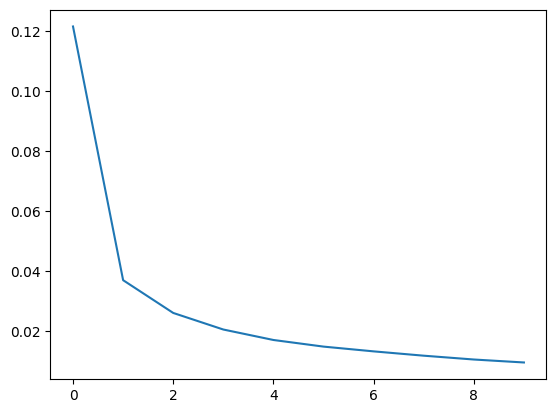

In [18]:
plt.plot(history.history['loss'])

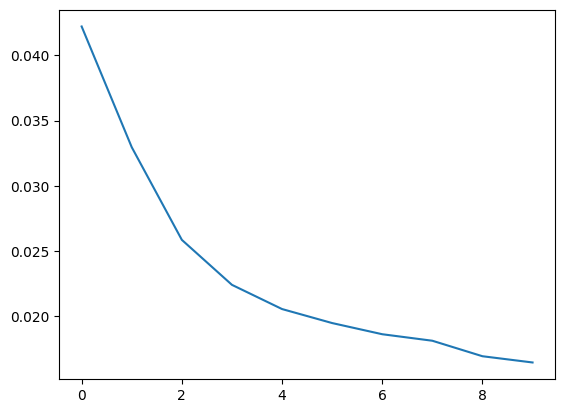

In [20]:
plt.plot(history.history['val_loss'])

In [22]:
# evaluate the model on the test datasets
model.evaluate(x_test, y_test)

730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0161


0.01583266817033291

In [23]:
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ ?                      │       542,416 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ ?                      │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ ?                      │         2,016 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ ?                      │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,379 (6.62 MB)

 Trainable params: 578,459 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,920 (4.41 MB)

In [24]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [25]:
user_latent_features[0]

array([-0.0231149 ,  0.08357393,  0.17507485,  0.00560583,  0.12711732,
        0.00807249, -0.00053355, -0.1220876 , -0.0244213 , -0.01238076,
        0.04225595, -0.06049881, -0.00460691,  0.02299638, -0.05102004,
        0.08115009], dtype=float32)

In [26]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


TODO: 
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`

Another way to make rating predictions is to use the above user & items embeddings as an input to a neural network by aggregating them into a single feature vector as input data `X`. 

With the interaction label `Y` such as a rating score or an enrollment mode, we can build our other standalone predictive models to approximate the mapping from `X` to `Y`

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [28]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

In [29]:
#load the rating dataset that contains a user-item interaction matrix
rating_df = pd.read_csv(rating_url)

In [30]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

In [31]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [32]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [33]:
# Merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [34]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3.0,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,3.0,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,3.0,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3.0,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Next, we can combine the user features (the column labels starting with `UFeature` and item features (the column labels starting with `CFeature`. In machine learning, there are many ways to aggregate two feature vectors such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:


In [35]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
regression_dataset.columns = [f"Feature{i}" for i in range(16)]
regression_dataset['rating'] = ratings
regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


By now, we have built the input dataset `X` and the output vector `y`:

In [36]:
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


In [37]:
trainset, testset = train_test_split(regression_dataset, test_size=.3, random_state = rs)

In [38]:
reg_model = linear_model.Ridge(alpha=0.2)

In [39]:
reg_model.fit(x_train, y_train)

Ridge(alpha=0.2)

In [40]:
y_preds = reg_model.predict(x_test)

In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_preds) 


0.03984539121427366

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [44]:
# Merge user embedding features
merged_df = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(merged_df, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [45]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3.0,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,3.0,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,3.0,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3.0,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Each user's embedding features and each item's embedding features are added to the dataset. Next, we perform element-wise add the user features (the column labels starting with `UFeature`) and item features (the column labels starting with `CFeature`).

In [46]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
interaction_dataset.columns = [f"Feature{i}" for i in range(16)]
interaction_dataset['rating'] = ratings
interaction_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


Next, let's use `LabelEncoder()` to encode our `rating` label to be categorical:

In [47]:
X = interaction_dataset.iloc[:, :-1]
y_raw = interaction_dataset.iloc[:, -1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [69]:
print(f"Input data shape: {X.shape}, Output data shape: {Y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


In [70]:
rndm_forest_model = RandomForestClassifier(random_state=rs)

rndm_forest_model.fit(X_train,Y_train)

RandomForestClassifier(random_state=123)

In [71]:
Y_pred = rndm_forest_model.predict(X_test)


In [72]:
Y_pred.shape

(46662,)

In [73]:
Y_test.shape

(46662,)

In [74]:
metrics.accuracy_score(Y_test, Y_pred)

0.9797908362264798

Text(0.5, 102.72222222222219, 'Ground Truth')

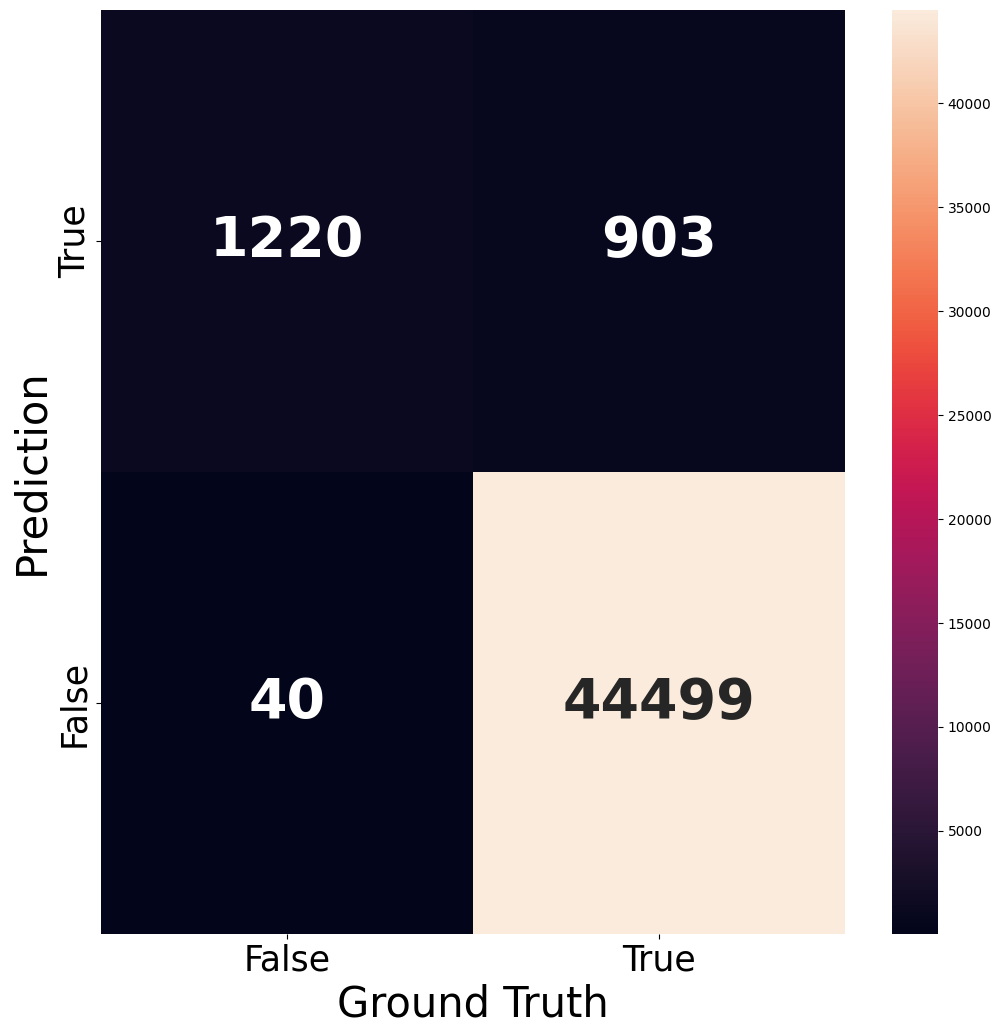

In [78]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score
# Plot confusion matrix
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

In [77]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.57      0.72      2123
           1       0.98      1.00      0.99     44539

    accuracy                           0.98     46662
   macro avg       0.97      0.79      0.86     46662
weighted avg       0.98      0.98      0.98     46662



In [80]:
print(roc_auc_score(Y_test,Y_pred))

0.7868802064023298
